## Read Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas
import numpy as np
import glob
from datetime import datetime
from geodata_functions import *
import re

#Generate inline plots
%matplotlib inline

files = [f for f in glob.glob("./data/csse_*.csv")]

dfs = []
columns = ['Province/State','Country/Region','Last Update','Confirmed']
for f in files:
    df = pd.read_csv(f,parse_dates=['Last Update'],usecols=columns)
    dfs.append(df)
    
    
df = pd.concat(dfs); df

Province/State  Country/Region         Last Update  Confirmed
0           Hubei  Mainland China 2020-02-01 10:00:00     7153.0
1        Zhejiang  Mainland China 2020-02-01 10:00:00      599.0
2       Guangdong  Mainland China 2020-02-01 10:00:00      535.0
3           Henan  Mainland China 2020-02-01 10:00:00      422.0
4           Hunan  Mainland China 2020-02-01 10:00:00      389.0
..            ...             ...                 ...        ...
58            NaN           Italy 2020-01-31 19:00:00        2.0
59            NaN          Sweden 2020-01-31 19:00:00        1.0
60            NaN          Russia 2020-01-31 19:00:00        2.0
61            NaN           Spain 2020-01-31 19:00:00        1.0
62            NaN              UK 2020-01-31 19:00:00        2.0

[2442 rows x 4 columns]

## Clean Data

In [2]:
# correct UK to United Kingdom
uk_idx = df['Country/Region'] == 'UK'
df.loc[uk_idx, 'Country/Region'] = 'United Kingom'

# convert state abbreviations to names
regex = r'^((?:\w+[ \-]?){1,4}), ([A-Z]{,2})$'
def city_state_to_state(row):
    text = row['Province/State']
    if pd.isna(text):
        return text
    
    match = re.match(regex, text)
    if match is None:
        return text
    group = match.groups()
    state = states_abbr_to_full[group[1]]
    return state

df['Province/State'] = df.apply(city_state_to_state, axis=1)
# df['D'] = (df.apply(lambda x: myfunc(x[colNames[0]], x[colNames[1]]), axis=1)) 
# df.info()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2442 entries, 0 to 62
Data columns (total 4 columns):
Province/State    1817 non-null object
Country/Region    2442 non-null object
Last Update       2442 non-null datetime64[ns]
Confirmed         2412 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 95.4+ KB


In [4]:
df['Location'] = df.apply(create_location, axis=1)
locations = df['Location'].unique().tolist()
len(locations)

80

## Data Range

In [5]:
dates = df['Last Update'].unique().tolist()
dates.sort()

date_rng = pd.date_range(start=dates[0], end=dates[len(dates)-1], freq='D')
date_rng

DatetimeIndex(['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10'],
              dtype='datetime64[ns]', freq='D')

## Time Series

In [6]:
location_timeseries = {}
location_details = {}
for location in locations:
    values = df[df['Location'] == location]
    ldf = values.set_index('Last Update').resample('D').mean()
    ldf = ldf.reindex(index=date_rng)
    location_timeseries[location] = ldf.fillna(method='ffill')
    #location_timeseries[location] = ldf.interpolate()
    location_details[location] = {
        'Province/State':values.iloc[0]['Province/State'], 
        'Country/Region':values.iloc[0]['Country/Region']}
    
location_timeseries['Japan']

Confirmed
2020-01-21   1.000000
2020-01-22   2.000000
2020-01-23   1.000000
2020-01-24   2.000000
2020-01-25   2.000000
2020-01-26   4.000000
2020-01-27   4.000000
2020-01-28   7.000000
2020-01-29   8.333333
2020-01-30  11.000000
2020-01-31  16.000000
2020-02-01  19.666667
2020-02-02  19.666667
2020-02-03  19.666667
2020-02-04  22.000000
2020-02-05  22.000000
2020-02-06  45.000000
2020-02-07  25.000000
2020-02-08  25.000000
2020-02-09  26.000000
2020-02-10  26.000000

In [7]:
daily_confirmed = pd.DataFrame(index=date_rng,columns=locations)

for location in locations:
    daily_confirmed[location] = location_timeseries[location]
    
daily_confirmed[['Russia','Japan','Hong Kong, Hong Kong','Hubei, Mainland China']]

Russia      Japan  Hong Kong, Hong Kong  Hubei, Mainland China
2020-01-21     NaN   1.000000                   NaN             270.000000
2020-01-22     NaN   2.000000                   NaN             444.000000
2020-01-23     NaN   1.000000              2.000000             444.000000
2020-01-24     NaN   2.000000              2.000000             549.000000
2020-01-25     NaN   2.000000              5.000000             847.333333
2020-01-26     NaN   4.000000              8.000000            1240.500000
2020-01-27     NaN   4.000000              8.000000            1853.333333
2020-01-28     NaN   7.000000              8.000000            3274.000000
2020-01-29     NaN   8.333333             10.000000            3898.000000
2020-01-30     NaN  11.000000             11.000000            5354.500000
2020-01-31     2.0  16.000000             12.500000            6479.500000
2020-02-01     2.0  19.666667             13.000000            8639.250000
2020-02-02     2.0  19.666667             14.833333           11177.000000
2020-02-03     2.0  19.666667             14.833333           11177.000000
2020-02-04     2.0  22.000000             17.000000           14311.000000
2020-02-05     2.0  22.000000             19.500000           16678.000000
2020-02-06     2.0  45.000000             24.000000           20888.500000
2020-02-07     2.0  25.000000             25.000000           22112.000000
2020-02-08     2.0  25.000000             26.000000           24953.000000
2020-02-09     2.0  26.000000             29.000000           27943.666667
2020-02-10     2.0  26.000000             36.000000           27943.666667

## View the data

In [8]:
def build_df_for_datetime(d):
    day_df = pd.DataFrame(daily_confirmed.loc[d])
    day_df.columns = ['Confirmed']
    day_df[['Province/State','Country/Region']] = day_df.apply(lambda x: pd.Series(location_details[x.name]), axis=1)
    day_df.dropna(subset=['Confirmed'], inplace=True)
    return day_df

d = date_rng[0]
day_df = build_df_for_datetime(d)
day_df

Confirmed Province/State  Country/Region
Hubei, Mainland China          270.0          Hubei  Mainland China
Zhejiang, Mainland China         5.0       Zhejiang  Mainland China
Guangdong, Mainland China       17.0      Guangdong  Mainland China
Henan, Mainland China            1.0          Henan  Mainland China
Hunan, Mainland China            1.0          Hunan  Mainland China
Jiangxi, Mainland China          2.0        Jiangxi  Mainland China
Chongqing, Mainland China        5.0      Chongqing  Mainland China
Sichuan, Mainland China          2.0        Sichuan  Mainland China
Shandong, Mainland China         1.0       Shandong  Mainland China
Shanghai, Mainland China         9.0       Shanghai  Mainland China
Beijing, Mainland China         10.0        Beijing  Mainland China
Yunnan, Mainland China           1.0         Yunnan  Mainland China
Tianjin, Mainland China          2.0        Tianjin  Mainland China
Japan                            1.0            NaN           Japan
Thailand                         2.0            NaN        Thailand
South Korea                      1.0            NaN     South Korea
Taiwan, Mainland China           1.0         Taiwan  Mainland China
Washington, United States        1.0     Washington   United States

In [9]:
ncov = build_ncov_geodf(day_df)
ncov[['name','Confirmed','geometry']].sort_values(by='Confirmed', ascending=False).head()

name  Confirmed                                           geometry
8       Hubei      270.0  MULTIPOLYGON (((109.46048 29.55436, 109.45979 ...
6   Guangdong       17.0  MULTIPOLYGON (((110.58903 20.37208, 110.58903 ...
4     Beijing       10.0  MULTIPOLYGON (((116.23775 39.51794, 116.23721 ...
17    Beijing       10.0  MULTIPOLYGON (((116.23775 39.51794, 116.23721 ...
12   Shanghai        9.0  MULTIPOLYGON (((121.70236 30.55958, 121.70236 ...

## Map plotting Data

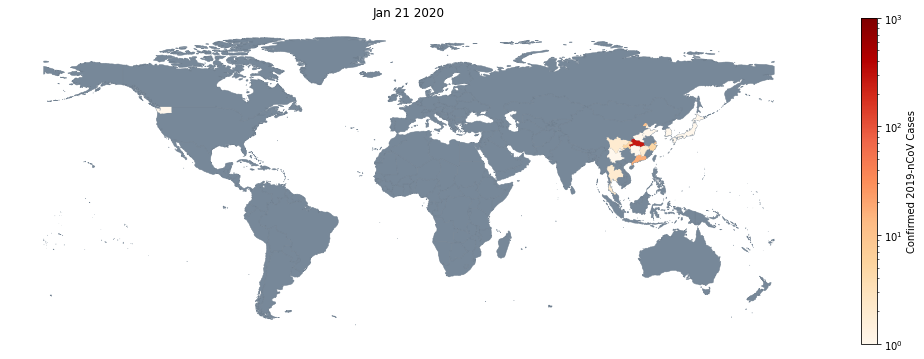

In [10]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

world_lines = geopandas.read_file('zip://./shapefiles/ne_50m_admin_0_countries.zip')
world = world_lines[(world_lines['POP_EST'] > 0) & (world_lines['ADMIN'] != 'Antarctica')]

fig, ax = plt.subplots(figsize=(18, 6))

world.plot(
    ax=ax,
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5);
ax.axis('off')

ax.set_title(d.strftime("%b %d %Y"))
ncov = build_ncov_geodf(day_df)

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')

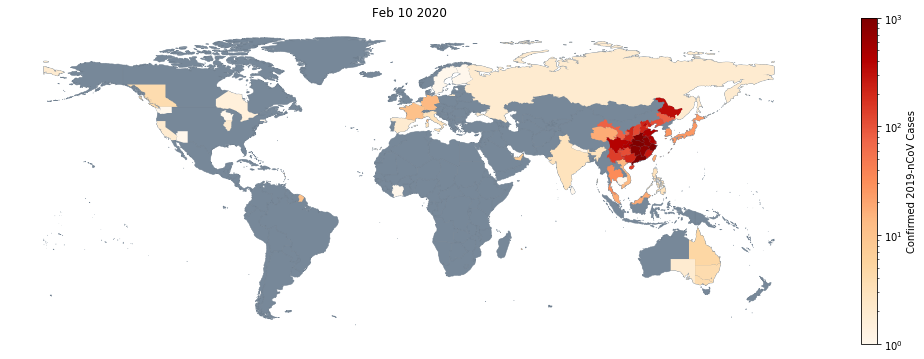

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))

world.plot(
    ax=ax,
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5);
ax.axis('off')

d = date_rng[len(date_rng)-1]
ax.set_title(d.strftime("%b %d %Y"))
day_df = build_df_for_datetime(d)
ncov = build_ncov_geodf(day_df)

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')


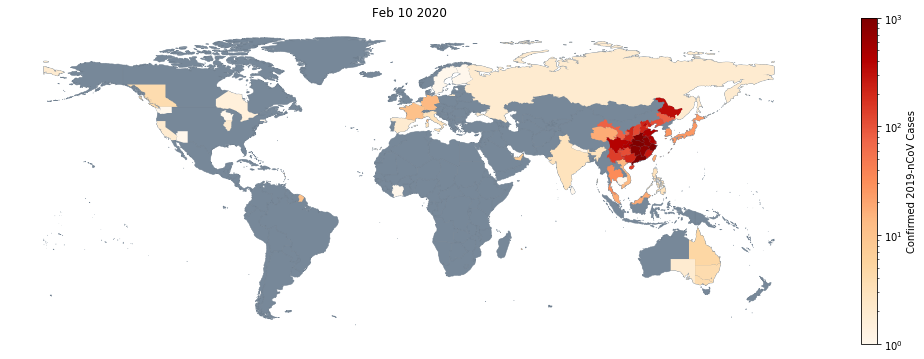

In [12]:
fig, ax = plt.subplots(figsize=(18, 6))

world.plot(
    ax=ax,
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5);
ax.axis('off')

d = date_rng[len(date_rng)-1]
ax.set_title(d.strftime("%b %d %Y"))
day_df = build_df_for_datetime(d)
ncov = build_ncov_geodf(day_df)

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')

# Visualization with shapely and Geopandas
## Plotting Specific Country


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas
import numpy as np
from shapely.geometry import Point
import math
data = pd.read_csv('./data/03-10-2020.csv',parse_dates=['Last Update'])
data.head()

Province/State              Country/Region         Last Update  Confirmed  \
0          Hubei              Mainland China 2020-03-10 15:13:05      67760   
1            NaN                       Italy 2020-03-10 17:53:02      10149   
2            NaN  Iran (Islamic Republic of) 2020-03-10 19:13:20       8042   
3            NaN           Republic of Korea 2020-03-10 19:13:20       7513   
4            NaN                      France 2020-03-10 18:53:02       1784   

   Deaths  Recovered  Latitude  Longitude  
0    3024      47743   30.9756   112.2707  
1     631        724   43.0000    12.0000  
2     291       2731   32.0000    53.0000  
3      54        247   36.0000   128.0000  
4      33         12   47.0000     2.0000

In [14]:
cases_by_country = data.groupby(['Country/Region'])['Confirmed'].sum().to_frame(name = 'Confirmed').reset_index()
cases_by_country.columns = ['country','confirmed']
cases_by_country.sort_values(by='confirmed', ascending=False, inplace=True)
cases_by_country.head()

country  confirmed
62              Mainland China      80757
52                       Italy      10149
48  Iran (Islamic Republic of)       8042
87           Republic of Korea       7513
36                      France       1784

Text(0.5, 1.0, 'Confirmed 2019-nCoV')

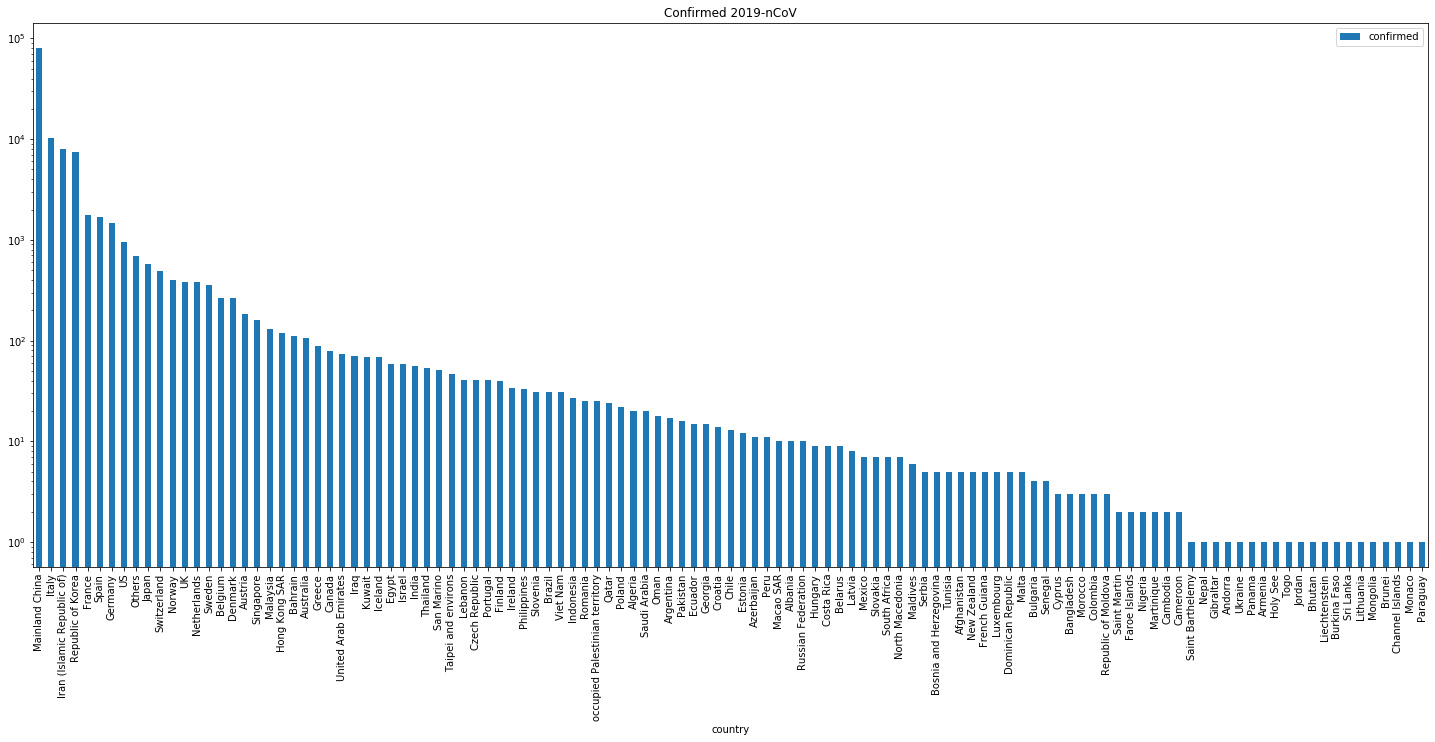

In [15]:
def location_label(row):
    if pd.isnull(row['Province/State']):
        return row['Country/Region']
    else:
        return row['Province/State']

ax = cases_by_country.plot.bar(x='country', y='confirmed', figsize=(25, 10))
ax.set_yscale('log')
ax.set_title('Confirmed 2019-nCoV')

# World Data

In [16]:
world_lines = geopandas.read_file('zip://./shapefiles/ne_50m_admin_0_countries.zip')

world = world_lines[(world_lines['POP_EST']>0) & (world_lines['ADMIN']!='Antarctica')]

world = world.rename(columns = {'ADMIN':'name'})

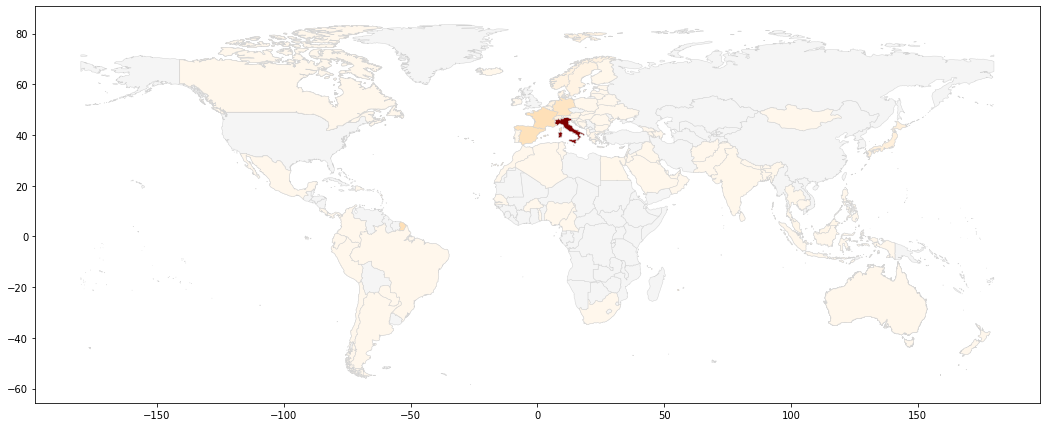

In [17]:
world_ncov = world.merge(data, left_on='name', right_on='Country/Region')

w_ax = world.plot(color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8));
world_ncov.plot(ax=w_ax, column='Confirmed', cmap='OrRd', edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8));

# China Data

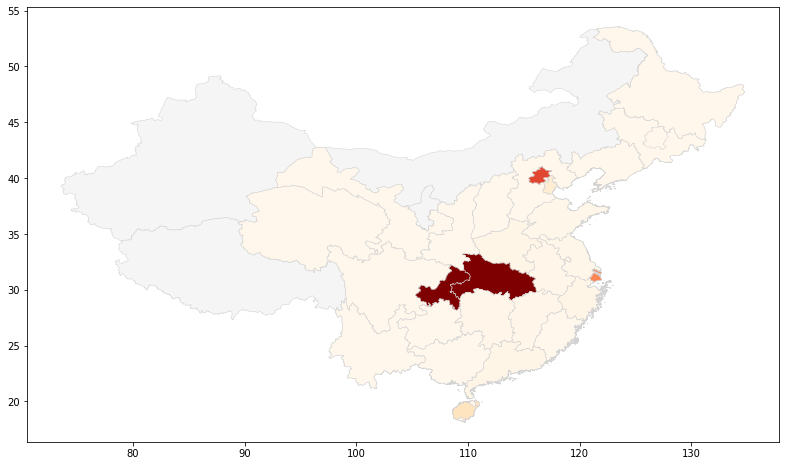

In [18]:
china = world_lines[world_lines['ADMIN']=='China']
# layers: ['gadm36_CHN_0', 'gadm36_CHN_1', 'gadm36_CHN_2', 'gadm36_CHN_3']
china_provinces = geopandas.read_file('./shapefiles/gadm36_CHN.gpkg', layer='gadm36_CHN_1')
china_provinces = china_provinces.rename(columns = {'NAME_1':'name'}) 

china_cities = geopandas.read_file('./shapefiles/gadm36_CHN.gpkg', layer='gadm36_CHN_2')
china_cities = china_cities.rename(columns = {'NAME_2':'name'}) 

# set to same projection
china_provinces.crs = china.crs
china_cities.crs = china.crs

# merge with coronavirus data
china_provinces_ncov = china_provinces.merge(data, left_on='name', right_on='Province/State')
china_cities_ncov = china_cities.merge(data, left_on='name', right_on='Province/State')

# include Hong Kong numbers in Guangdong
g_idx = china_provinces['name']=='Guangdong'
hk_confirmed = data.loc[data['Province/State']=='Hong Kong','Confirmed'].values[0]
china_provinces_ncov.loc[g_idx,'Confirmed'] += hk_confirmed

cn_ax = china_provinces.plot(color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8))
china_provinces_ncov.plot(ax=cn_ax, column='Confirmed', cmap='OrRd', edgecolor = "lightgrey", linewidth = 0.5);
china_cities_ncov.plot(ax=cn_ax, column='Confirmed', cmap='OrRd', edgecolor = "lightgrey", linewidth = 0.5);

# USA Data

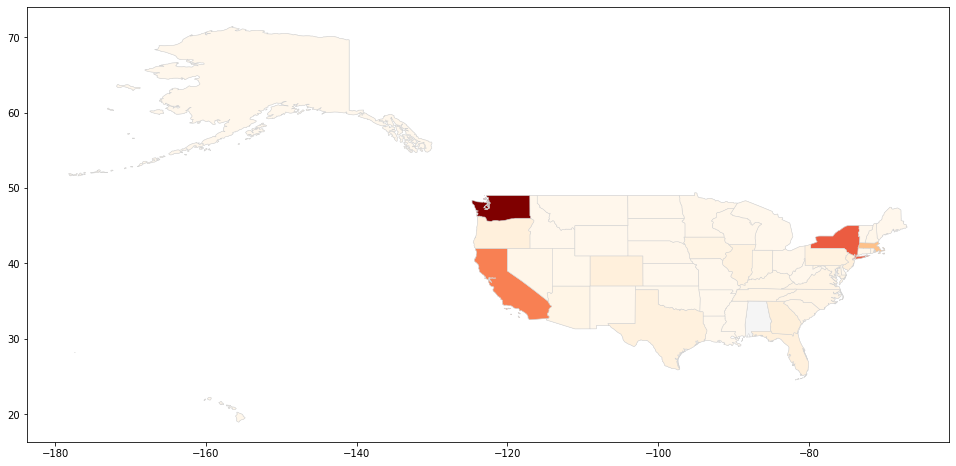

In [19]:
state_lines = geopandas.read_file('zip://./shapefiles/ne_50m_admin_1_states_provinces.zip')
us_state_lines = state_lines[state_lines['iso_a2']=='US']

# merge with coronavirus data
us_state_ncov = us_state_lines.merge(data, left_on='name', right_on='Province/State')

us_ax = us_state_lines.plot(color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8));
us_state_ncov.plot(ax=us_ax, column='Confirmed', cmap='OrRd', edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8));

## Combine Geolocation Data

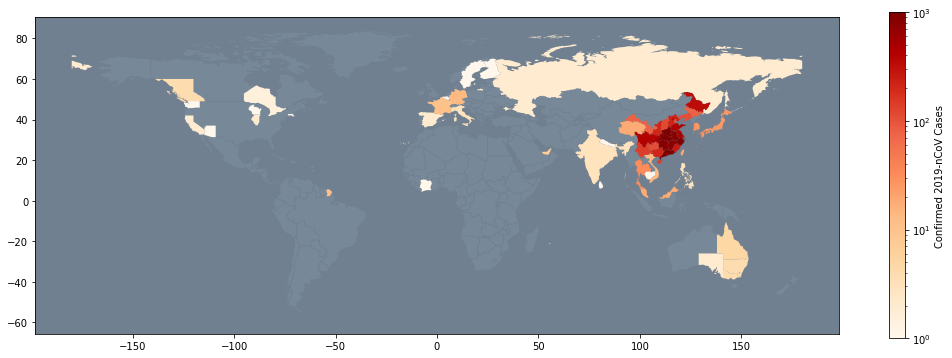

In [20]:
ax = world.plot(
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5, figsize=(18, 6));
ax.set_facecolor("slategray")
ax.set_clip_on(False)
#ax.axis('off')

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')

## Scope Data in Wuhan, China

In [21]:
import numpy as np
from dataclasses import dataclass
from typing import List
from scipy.stats import nbinom, t
import matplotlib.pyplot as plt
from scipy import stats
import random
import math
from math import lgamma
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
from helper_functions import *

2019-01-21 
Scenario: Baseline
Exported number of confirmed cases: 7
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 19000000

Estimated number of cases in Wuhan: 4029.0820963344436
Estimated 95% confidence interval: (1730, 7780)

------------------------------------------------------------------------------------



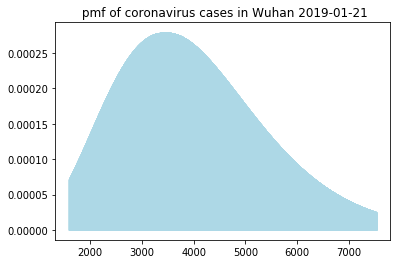

In [22]:
# Baseline
wuhan_case_Jan21 = Estimate_wuhan_case(model_name = 'Baseline', date = '2019-01-21', 
                                      wuhan = Wuhan(population=11000000, 
                                                    airportCatchment=19000000, 
                                                    internationalTraveller=3301),
                                      international = International(cases = 7),
                                      coronavirus = Coronavirus(incubation=6, 
                                                                onsetTodetection=4))

print(wuhan_case_Jan21)
# Plot the distrubution of estimated Coronavirus cases in Wuhan 
wuhan_case_Jan21.plot_distribution()

In [23]:
# 2019-01-21: same result as papers 
sensitivity_analysis(date='2019-01-21', wuhan_population=11000000,
                     airportCatchment=19000000,international_case=7, 
                     onsetTodetection=4)

2019-01-21 
Scenario: Baseline
Exported number of confirmed cases: 7
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 19000000

Estimated number of cases in Wuhan: 4029.0820963344436
Estimated 95% confidence interval: (1730, 7780)

------------------------------------------------------------------------------------

2019-01-21 
Scenario: Smaller catchment
Exported number of confirmed cases: 7
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 11000000

Estimated number of cases in Wuhan: 2332.6264768252045
Estimated 95% confidence interval: (1000, 4490)

------------------------------------------------------------------------------------

2019-01-21 
Scenario: Shorter detection window
Exported number of confirmed c

In [24]:
# 8 exported cases until Jan 22 
# 29 exported cases until Jan 26 
sensitivity_analysis(date='2019-01-22', wuhan_population=11000000,
                        airportCatchment=19000000,international_case=8, onsetTodetection=4)

2019-01-22 
Scenario: Baseline
Exported number of confirmed cases: 8
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 19000000

Estimated number of cases in Wuhan: 4604.6652529536495
Estimated 95% confidence interval: (2100, 8550)

------------------------------------------------------------------------------------

2019-01-22 
Scenario: Smaller catchment
Exported number of confirmed cases: 8
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 11000000

Estimated number of cases in Wuhan: 2665.8588306573765
Estimated 95% confidence interval: (1220, 4940)

------------------------------------------------------------------------------------

2019-01-22 
Scenario: Shorter detection window
Exported number of confirmed c

In [25]:
# 2019-01-29: 67 confirmed cases overseas
sensitivity_analysis(date='2019-01-29', wuhan_population=11000000,
                     airportCatchment=19000000,international_case=67, 
                     onsetTodetection=4)

2019-01-29 
Scenario: Baseline
Exported number of confirmed cases: 67
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 19000000

Estimated number of cases in Wuhan: 38564.071493486816
Estimated 95% confidence interval: (30000, 48470)

------------------------------------------------------------------------------------

2019-01-29 
Scenario: Smaller catchment
Exported number of confirmed cases: 67
Detection Window: 10
Time from onset of symptoms to detection: 4
Daily International passengers travelling out of Wuhan: 3301
Effective catchment population of Wuhan Interntional Airport: 11000000

Estimated number of cases in Wuhan: 22326.56770675553
Estimated 95% confidence interval: (17340, 28030)

------------------------------------------------------------------------------------

2019-01-29 
Scenario: Shorter detection window
Exported number of confir

In [26]:
# import xgboost
# import shap

# # load JS visualization code to notebook
# shap.initjs()

# # train XGBoost model
# X,y = shap.datasets.boston()
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)

# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [27]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from IPython.core.display import display, HTML
from pylab import rcParams
# Loading datasets from GitHub repository https://github.com/CSSEGISandData/COVID-19
dataCovidTSconfirmed = pd.read_csv("./data/time_series_19-covid-Confirmed.csv")
dataCovidTSdeaths = pd.read_csv("./data/time_series_19-covid-Deaths.csv")
dataCovidTSrecovered = pd.read_csv("./data/time_series_19-covid-Recovered.csv")

In [28]:
# additional configuration options
pd.set_option('precision', 2)
%matplotlib inline
rcParams['figure.figsize'] = 12, 8

In [29]:
# Aighlighting a column in a table
def highlight_cols(s, coldict):
    if s.name in coldict.keys():
            return ['background-color: {}'.format(coldict[s.name])]*len(s)
    return ['']*len(s)

# Adding a text label in a bar chart
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [30]:
data.head(10)

Province/State              Country/Region         Last Update  Confirmed  \
0          Hubei              Mainland China 2020-03-10 15:13:05      67760   
1            NaN                       Italy 2020-03-10 17:53:02      10149   
2            NaN  Iran (Islamic Republic of) 2020-03-10 19:13:20       8042   
3            NaN           Republic of Korea 2020-03-10 19:13:20       7513   
4            NaN                      France 2020-03-10 18:53:02       1784   
5            NaN                       Spain 2020-03-10 23:53:02       1695   
6            NaN                     Germany 2020-03-10 18:53:02       1457   
7      Guangdong              Mainland China 2020-03-10 09:13:07       1353   
8          Henan              Mainland China 2020-03-08 05:03:02       1272   
9       Zhejiang              Mainland China 2020-03-10 10:33:02       1215   

   Deaths  Recovered  Latitude  Longitude  
0    3024      47743     30.98     112.27  
1     631        724     43.00      12.00  
2     291       2731     32.00      53.00  
3      54        247     36.00     128.00  
4      33         12     47.00       2.00  
5      35         32     40.00      -4.00  
6       2         18     51.00       9.00  
7       8       1274     23.34     113.42  
8      22       1247     33.88     113.61  
9       1       1191     29.18     120.09

In [31]:
# Calculating the sum of all confirmed cases
result = data['Confirmed'].sum()
display(HTML('<p style="font-size:18px">There are <strong style="color:#ff0000">'+ format(result, ",d") +'</strong> confirmed Coronavirus cases.</p>'))

In [32]:
# Calculating the sum of all death cases
result = data['Deaths'].sum()
display(HTML('<p style="font-size:18px">There are <strong style="color:#ff0000">'+ format(result, ",d") +'</strong> confirmed deaths from Coronavirus.</p>'))

In [33]:
# Calculating the sum of all recovered cases
result = data['Recovered'].sum()
display(HTML('<p style="font-size:18px"><strong style="color:#ff0000">'+ format(result, ",d") +'</strong> already recovered from Coronavirus.</p>'))

In [34]:
# Calculating the percentage of deaths
result = (data['Deaths'].sum()/data['Confirmed'].sum())*100
display(HTML('<p style="font-size:18px"><strong style="color:#ff0000">'+ str(round(result, 2)) +'%</strong> of all people infected with Coronavirus died.</p>'))

In [35]:
# Calculating the percentage of recovered
result = (data['Recovered'].sum()/data['Confirmed'].sum())*100
display(HTML('<p style="font-size:18px"><strong style="color:#ff0000">'+ str(round(result, 2)) +'%</strong> of all people infected with Coronavirus already recovered.</p>'))

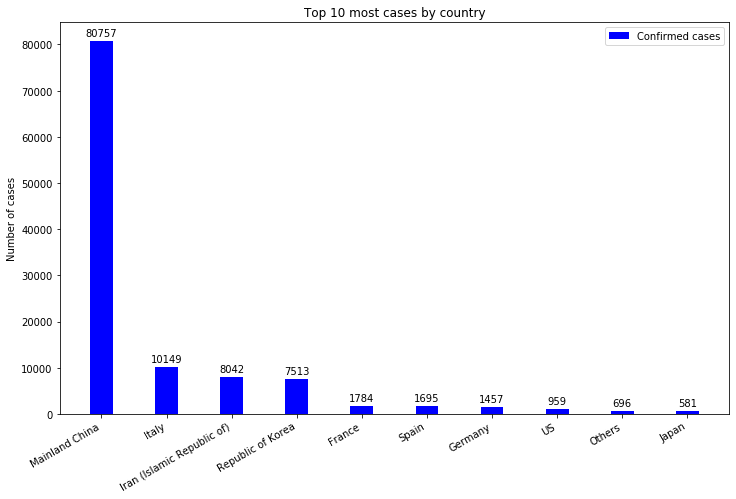

In [36]:
# Getting the sum for each country and sorting it by a number of cases
result = data.groupby(['Country/Region']).sum()
result = result.sort_values(['Confirmed'], ascending=False)

# Limiting to top 10
labels = result.index.values[:10]
confirmed = result['Confirmed'][:10]

# Chart configuration
width = 0.35
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.bar(labels, confirmed, width, label='Confirmed cases', color='blue')
ax.set_ylabel('Number of cases')
ax.set_title('Top 10 most cases by country')
ax.legend()
x = np.arange(len(labels))
rects1 = ax.bar(x, confirmed, width, color='blue')
autolabel(rects1)

# Chart display
plt.show()

# Showing the results in a table and highlighting sorted by column
coldict = {'Confirmed': 'rgb(230,220,240)'}
result[['Confirmed', 'Deaths', 'Recovered']].head(10).style.apply(highlight_cols, coldict=coldict)

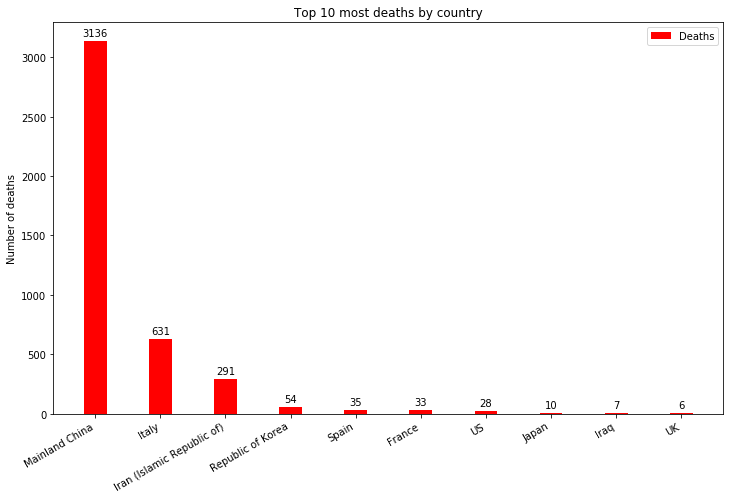

In [37]:
# Getting the sum for each country, calculating % and sorting it by a number of deaths
result = data.groupby(['Country/Region']).sum()
result['Deaths %'] = round((result['Deaths']/result['Confirmed'])*100, 2)
result = result.sort_values(['Deaths'], ascending=False)

# Limiting to top 10
labels = result.index.values[:10]
confirmed = result['Deaths'][:10]

# Chart configuration
width = 0.35 
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.bar(labels, confirmed, width, label='Deaths', color='red')
ax.set_ylabel('Number of deaths')
ax.set_title('Top 10 most deaths by country')
ax.legend()
x = np.arange(len(labels))
rects1 = ax.bar(x, confirmed, width, color='red')
autolabel(rects1)

# Chart display
plt.show()

# Showing the results in a table and highlighting sorted by column
coldict = {'Deaths': 'rgb(230,220,240)'}
result[['Confirmed', 'Deaths', 'Deaths %']].head(10).style.apply(highlight_cols, coldict=coldict)

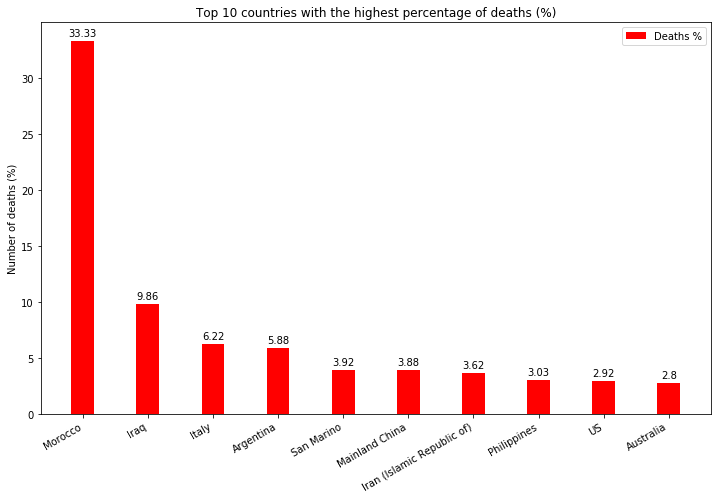

In [38]:
# Getting the sum for each country, calculating % and sorting it by a number of deaths %
result = data.groupby(['Country/Region']).sum()
result['Deaths %'] = round((result['Deaths']/result['Confirmed'])*100, 2)
result = result.sort_values(['Deaths %', 'Confirmed'], ascending=[False, False])

# Limiting to top 10
labels = result.index.values[:10]
confirmed = result['Deaths %'][:10]

# Chart configuration
width = 0.35 
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.bar(labels, confirmed, width, label='Deaths %', color='red')
ax.set_ylabel('Number of deaths (%)')
ax.set_title('Top 10 countries with the highest percentage of deaths (%)')
ax.legend()
x = np.arange(len(labels))
rects1 = ax.bar(x, confirmed, width, color='red')
autolabel(rects1)

# Chart display
plt.show()

# Showing the results in a table and highlighting sorted by column
coldict = {'Deaths %': 'rgb(230,220,240)'}
result[['Confirmed', 'Deaths', 'Deaths %']].head(10).style.apply(highlight_cols, coldict=coldict)

In [39]:
# Getting the sum for each country, calculating % and sorting it by a number of deaths %
result = data.groupby(['Country/Region']).sum()
result['Deaths %'] = round((result['Deaths']/result['Confirmed'])*100, 2)
result = result.sort_values(['Deaths %', 'Confirmed'], ascending=[True, False])

# Displaying the number of countries with deaths == 0
display(HTML('<p style="font-size:18px"><strong style="color:#ff0000">'+ str(len(result.loc[result['Deaths'] == 0])) +'</strong> countries that reported coronavirus cases have no reported deaths from coronavirus.</p>'))

# Showing the results in a table and highlighting the column
coldict = {'Deaths': 'rgb(230,220,240)'}
result[['Confirmed', 'Deaths', 'Deaths %']].loc[result['Deaths'] == 0][:10].style.apply(highlight_cols, coldict=coldict)

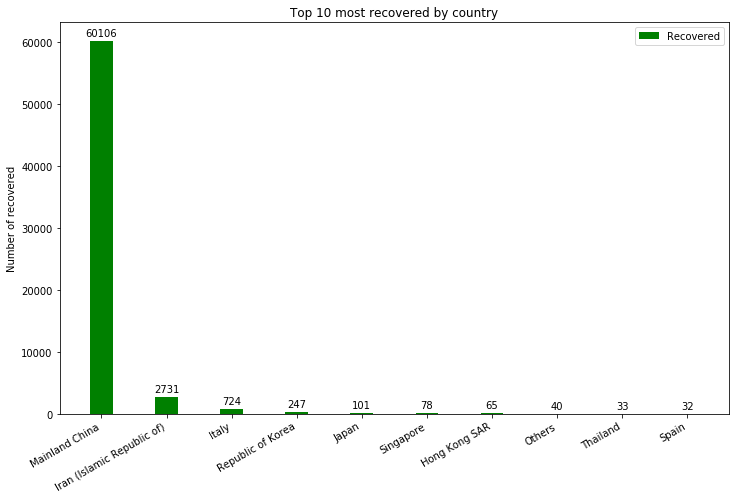

In [40]:
# Getting the sum for each country, calculating % and sorting it by a number of recovered
result = data.groupby(['Country/Region']).sum()
result['Recovered %'] = round((result['Recovered']/result['Confirmed'])*100, 2)
result = result.sort_values(['Recovered'], ascending=False)

# Limiting to top 10
labels = result.index.values[:10]
confirmed = result['Recovered'][:10]

# Chart configuration
width = 0.35
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.bar(labels, confirmed, width, label='Recovered', color='green')
ax.set_ylabel('Number of recovered')
ax.set_title('Top 10 most recovered by country')
ax.legend()
x = np.arange(len(labels))
rects1 = ax.bar(x, confirmed, width, color='green')
autolabel(rects1)

# Chart display
plt.show()

# Showing the results in a table and highlighting sorted by column
coldict = {'Recovered': 'rgb(230,220,240)'}
result[['Confirmed', 'Recovered', 'Recovered %']].head(10).style.apply(highlight_cols, coldict=coldict)

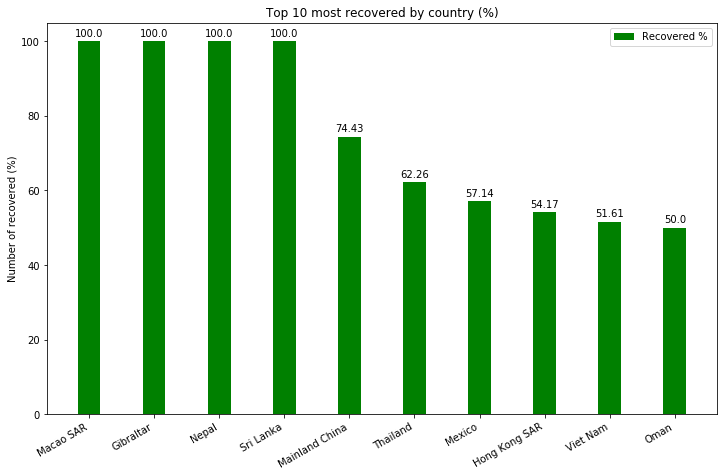

In [41]:
# Getting the sum for each country, calculating % and sorting it by a number of recovered %
result = data.groupby(['Country/Region']).sum()
result['Recovered %'] = round((result['Recovered']/result['Confirmed'])*100, 2)
result = result.sort_values(['Recovered %', 'Recovered'], ascending=[False, False])

# Limiting to top 10
labels = result.index.values[:10]
confirmed = result['Recovered %'][:10]

# Chart configuration
width = 0.35
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.bar(labels, confirmed, width, label='Recovered %', color='green')
ax.set_ylabel('Number of recovered (%)')
ax.set_title('Top 10 most recovered by country (%)')
ax.legend()
x = np.arange(len(labels))
rects1 = ax.bar(x, confirmed, width, color='green')
autolabel(rects1)

# Chart display
plt.show()

# Showing the results in a table and highlighting sorted by column
coldict = {'Recovered': 'rgb(230,220,240)'}
result[['Confirmed', 'Recovered', 'Recovered %']].head(10).style.apply(highlight_cols, coldict=coldict)

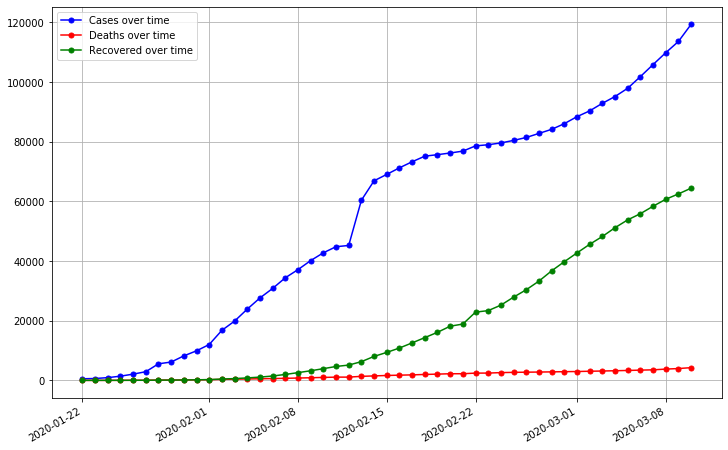

In [42]:
# Getting X labels
X = dataCovidTSconfirmed.columns.values[4:]
X = pd.to_datetime(X)

# Getting y values for confirmed cases
resultConfirmed = dataCovidTSconfirmed.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yConfirmed = resultConfirmed.sum().values

# Getting y values for deaths
resultDeaths = dataCovidTSdeaths.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yDeaths = resultDeaths.sum().values

# Getting y values for recovered
resultRecovered = dataCovidTSrecovered.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yRecovered = resultRecovered.sum().values

# Chart configuration
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.grid(True)
plt.plot(X, yConfirmed, color='blue', label='Cases over time', marker=".", markersize=10)
plt.plot(X, yDeaths, color='red', label='Deaths over time', marker=".", markersize=10)
plt.plot(X, yRecovered, color='green', label='Recovered over time', marker=".", markersize=10)
plt.legend()

# Chart display
plt.show()

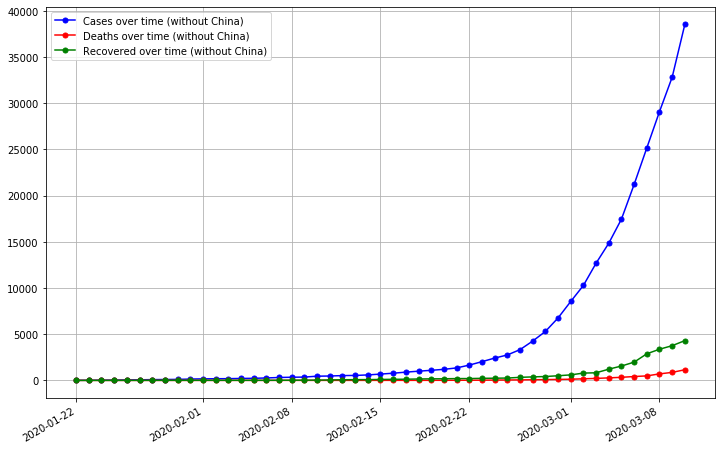

In [43]:
# Getting X labels
X = dataCovidTSconfirmed.columns.values[4:]
X = pd.to_datetime(X)

# Getting y values for confirmed cases
dataCovidTSconfirmedNoChina = dataCovidTSconfirmed[dataCovidTSconfirmed['Country/Region'] != 'Mainland China']
resultConfirmed = dataCovidTSconfirmedNoChina.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yConfirmed = resultConfirmed.sum().values

# Getting y values for deaths
dataCovidTSdeathsNoChina = dataCovidTSdeaths[dataCovidTSdeaths['Country/Region'] != 'Mainland China']
resultDeaths = dataCovidTSdeathsNoChina.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yDeaths = resultDeaths.sum().values

# Getting y values for recovered
resultRecoveredNoChina = dataCovidTSrecovered[dataCovidTSrecovered['Country/Region'] != 'Mainland China']
resultRecovered = resultRecoveredNoChina.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yRecovered = resultRecovered.sum().values

# Chart configuration
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.grid(True)
plt.plot(X, yConfirmed, color='blue', label='Cases over time (without China)', marker=".", markersize=10)
plt.plot(X, yDeaths, color='red', label='Deaths over time (without China)', marker=".", markersize=10)
plt.plot(X, yRecovered, color='green', label='Recovered over time (without China)', marker=".", markersize=10)
plt.legend()

# Chart display
plt.show()



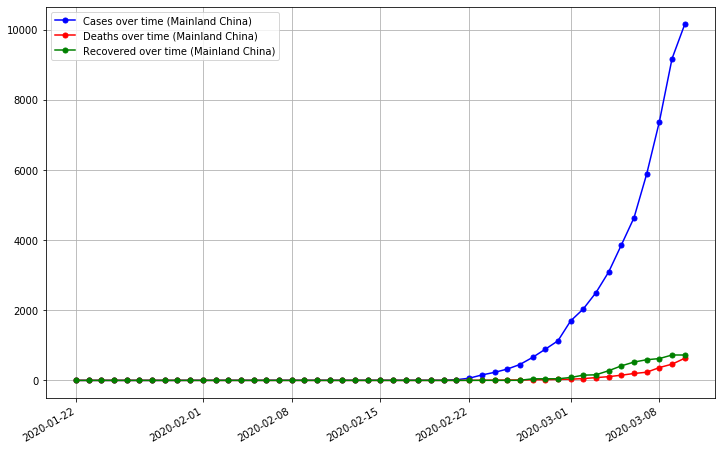

In [44]:
# Getting X labels
X = dataCovidTSconfirmed.columns.values[4:]
X = pd.to_datetime(X)

# Getting y values for confirmed cases
dataCovidTSconfirmedItaly = dataCovidTSconfirmed[dataCovidTSconfirmed['Country/Region'] == 'Italy']
resultConfirmed = dataCovidTSconfirmedItaly.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yConfirmed = resultConfirmed.sum().values

# Getting y values for deaths
dataCovidTSdeathsItaly = dataCovidTSdeaths[dataCovidTSdeaths['Country/Region'] == 'Italy']
resultDeaths = dataCovidTSdeathsItaly.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yDeaths = resultDeaths.sum().values

# Getting y values for recovered
resultRecoveredItaly = dataCovidTSrecovered[dataCovidTSrecovered['Country/Region'] == 'Italy']
resultRecovered = resultRecoveredItaly.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yRecovered = resultRecovered.sum().values

# Chart configuration
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.grid(True)
plt.plot(X, yConfirmed, color='blue', label='Cases over time (Mainland China)', marker=".", markersize=10)
plt.plot(X, yDeaths, color='red', label='Deaths over time (Mainland China)', marker=".", markersize=10)
plt.plot(X, yRecovered, color='green', label='Recovered over time (Mainland China)', marker=".", markersize=10)
plt.legend()

# Chart display
plt.show()

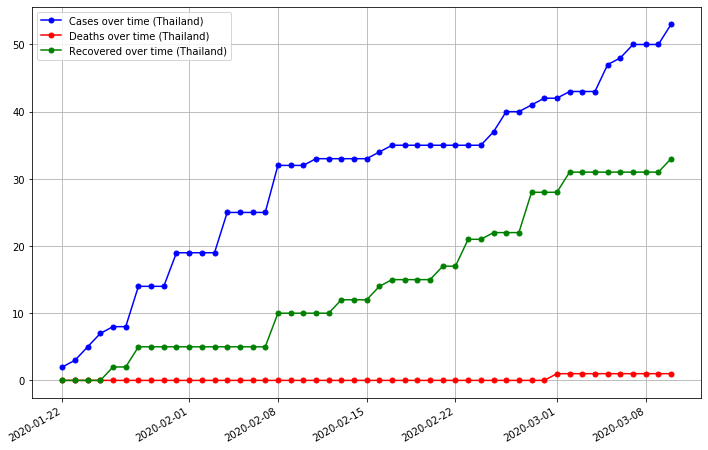

In [45]:
# Getting X labels
X = dataCovidTSconfirmed.columns.values[4:]
X = pd.to_datetime(X)

# Getting y values for confirmed cases
dataCovidTSconfirmedThai = dataCovidTSconfirmed[dataCovidTSconfirmed['Country/Region'] == 'Thailand']
resultConfirmed = dataCovidTSconfirmedThai.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yConfirmed = resultConfirmed.sum().values

# Getting y values for deaths
dataCovidTSdeathsThai = dataCovidTSdeaths[dataCovidTSdeaths['Country/Region'] == 'Thailand']
resultDeaths = dataCovidTSdeathsThai.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yDeaths = resultDeaths.sum().values

# Getting y values for recovered
resultRecoveredThai = dataCovidTSrecovered[dataCovidTSrecovered['Country/Region'] == 'Thailand']
resultRecovered = resultRecoveredThai.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yRecovered = resultRecovered.sum().values

# Chart configuration
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.grid(True)
plt.plot(X, yConfirmed, color='blue', label='Cases over time (Thailand)', marker=".", markersize=10)
plt.plot(X, yDeaths, color='red', label='Deaths over time (Thailand)', marker=".", markersize=10)
plt.plot(X, yRecovered, color='green', label='Recovered over time (Thailand)', marker=".", markersize=10)
plt.legend()

# Chart display
plt.show()

# Prediction for the number of cases and deaths in the following months (all countries)

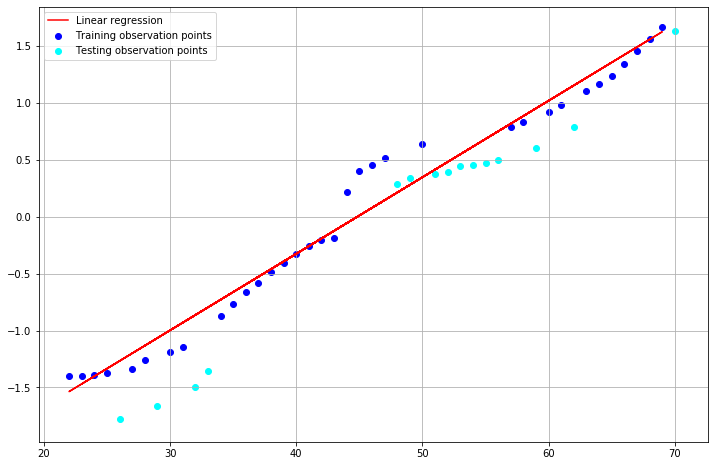

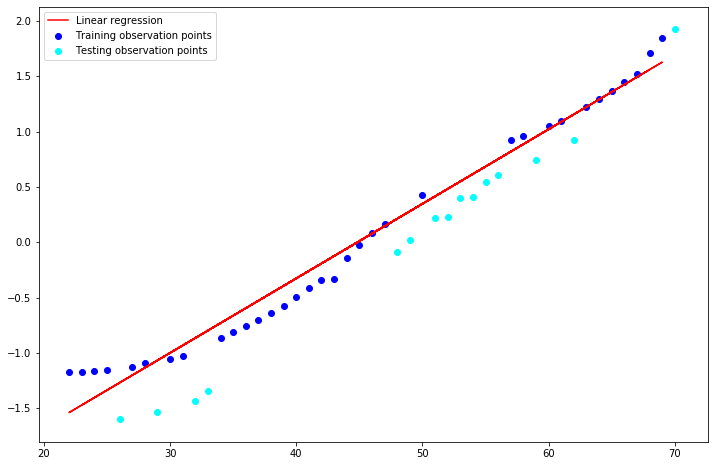

In [54]:
# Getting X labels
X = dataCovidTSconfirmed.columns.values[4:]

# Converting dates to a day of year number
Xnew = pd.DataFrame(X)
Xnew = pd.to_datetime(Xnew[0])
Xnew.index += 22
X = Xnew.index.values

# Getting y values for confirmed cases
resultฉ  = dataCovidTSconfirmed.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yConfirmed = resultConfirmed.sum().values

# Getting y values for deaths
resultDeaths = dataCovidTSdeaths.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yDeaths = resultDeaths.sum().values

# Getting y values for recovered
resultRecovered = dataCovidTSrecovered.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
yRecovered = resultRecovered.sum().values

# Chart configuration
fig, ax = plt.subplots()
# fig.autofmt_xdate()
ax.grid(True)

def predictForDate(day, month, year, yData, txt, plot, fontsize):
    
    predictDayNumber = datetime.datetime(year, month, day, 0, 0, 0).timetuple().tm_yday

    # Linear regression
    X_train, X_test, y_train, y_test = train_test_split(X, yData, test_size=3/10, random_state=0)

    scale_X = StandardScaler()
    scale_y = StandardScaler()

    X_train = X_train.reshape(-1, 1)
    y_train = scale_y.fit_transform(y_train.reshape(-1, 1))

    X_test = X_test.reshape(-1, 1)
    y_test = scale_y.fit_transform(y_test.reshape(-1, 1))

    # Scatter Plot
    if (plot):
        plt.scatter(X_train, y_train, color='blue', label='Training observation points')
        plt.scatter(X_test, y_test, color='cyan', label='Testing observation points')

    # LINEAR REGRESSION MODEL
    reg = linear_model.LinearRegression()

    reg.fit(X_train, y_train)
    if (plot):
        plt.plot(X_train, reg.predict(X_train), color='red', label='Linear regression')

    # LINEAR REGRESSION - Predict/Test model
    y_predict_linear = reg.predict(X_test)

    # LINEAR REGRESSION - Predict
    prediction_for = [[predictDayNumber]]

    linear_predict = scale_y.inverse_transform(reg.predict(prediction_for))[0][0]

    # LINEAR REGRESSION - Accuracy
    accuracy = reg.score(X_test, y_test)

    # LINEAR REGRESSION - Error
    error = round(np.mean((y_predict_linear-y_test)**2), 2)

    # Results
    display(HTML('<p style="font-size:' + str(fontsize) + 'px">The number of <strong>' + txt + '</strong> predicted for <strong>' + str(day) + '.' + str(month) + '.' + str(year) + '</strong> is <strong style="color:#ff0000">'+ str(int(linear_predict)) +'</strong> <span style="color:rgb(120,120,120)">(Model accuracy: ' + str("{0:.2f}".format(accuracy*100)) + '%, Model error: ' + str("{0:.2f}".format(error)) + ')</span>.</p>'))

    if (plot):
        plt.legend()
        plt.show()


# Predicting confirmed cases
predictForDate(31,3,2020, yConfirmed, 'confirmed cases', False, 18)
predictForDate(30,6,2020, yConfirmed, 'confirmed cases', False, 12)
predictForDate(31,12,2020, yConfirmed, 'confirmed cases', True, 12)

# Predicting deaths
predictForDate(31,3,2020, yDeaths, 'deaths', False, 18)
predictForDate(30,6,2020, yDeaths, 'deaths', False, 12)
predictForDate(31,1,2021, yDeaths, 'deaths', True, 12)

In [47]:
import shap